In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_mnist_test_files function

from generate_input_files.generate_mnist_xmodels_test_files import generate_mnist_xmodel_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_model_test_storage")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "storage", "increasing_model_test_storage")

# Step 1: Generate MNIST test files with multiple models
conv_units_list = [8, 16, 32, 64, 128]
print("Generating MNIST test files and models...")
generated_files = generate_mnist_xmodel_test_files(tmp_folder, conv_units_list)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_files = generated_files["models"]

Generating MNIST test files and models...
MNIST images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_definition.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_dataset.zip
Model with 8 units saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_model_8_units.keras
Model with 16 units saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_model_16_units.keras
Model with 32 units saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_model_test_storage\mnist_model

In [3]:
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the model complexities to test (e.g., units in a convolutional layer)
model_mapping = {}  # Dictionary to map model complexity to unique_dir and job_id

# Step 2: Submit jobs with increasing model complexity
for model_file, units in zip(model_files, conv_units_list):
    print(f"\nSubmitting job with {units} units in the convolutional layer...")

    # Prepare the files and data for the request
    files = {
        "model": open(model_file, "rb"),
        "dataset": open(dataset_filename, "rb"),
        "dataset_definition": open(yaml_filename, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"storage_analysis_model_{units}_units",
        "epochs": 1,
    }

    # Submit the job
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted: {response.status_code} {response.text}")

    # Extract the unique_dir and job_id from the API response
    response_data = response.json()
    unique_dir = response_data.get("unique_dir")
    job_id = response_data.get("job_id")  # Assuming the API returns a job_id
    if not unique_dir:
        raise ValueError("Error: 'unique_dir' not found in the API response.")

    # Store the mapping
    model_mapping[units] = {"unique_dir": unique_dir, "job_id": job_id}

    # Wait for the job to finish and download the results
    print(f"Waiting for job with {units} units to complete...")
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
    print(f"Artifacts for {units} units downloaded to: {DOWNLOAD_DIR}")


Submitting job with 8 units in the convolutional layer...
Submitted: 200 {"job_id":"011a3c64-b63a-442c-900d-bad21ec6c9b2","status":"Training started","unique_dir":"e8a64941-0e15-4637-8c8e-f616879d3f64"}
Waiting for job with 8 units to complete...
Checking if job is finished by looking for 'output' folder in 'e8a64941-0e15-4637-8c8e-f616879d3f64'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'e8a64941-0e15-4637-8c8e-f616879d3f64'...
Downloaded: e8a64941-0e15-4637-8c8e-f616879d3f64/dataset/mnist_dataset.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_model_test_storage\e8a64941-0e15-4637-8c8e-f616879d3f64/dataset/mnist_dataset.zip
Downloaded: e8a64941-0e15-4637-8c8e-f616879d3f64/definition/mnist_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_model_test_storage\e8a64941-0e15-4637-8c

   Units  Dataset Size (KB)  Definition Size (KB)  Input Model Size (KB)  \
0      8        1923.439453               0.12207             708.063477   
1     16        1923.439453               0.12207            1384.952148   
2     32        1923.439453               0.12207            2738.702148   
3     64        1923.439453               0.12207            5446.203125   
4    128        1923.439453               0.12207           10861.205078   

   Trained Model Size (KB)  AIBOM Size (KB)  Logs Size (KB)  \
0              2071.220703        13.287109        4.251953   
1              4101.860352        13.286133        4.251953   
2              8163.110352        13.287109        4.251953   
3             16285.611328        13.289062        4.251953   
4             32530.614258        13.291016        4.251953   

   Metrics Size (KB)  RunLink Size (KB)  Total Job Folder Size (KB)  \
0           0.132812           1.275391                 4721.792969   
1           0.129883  

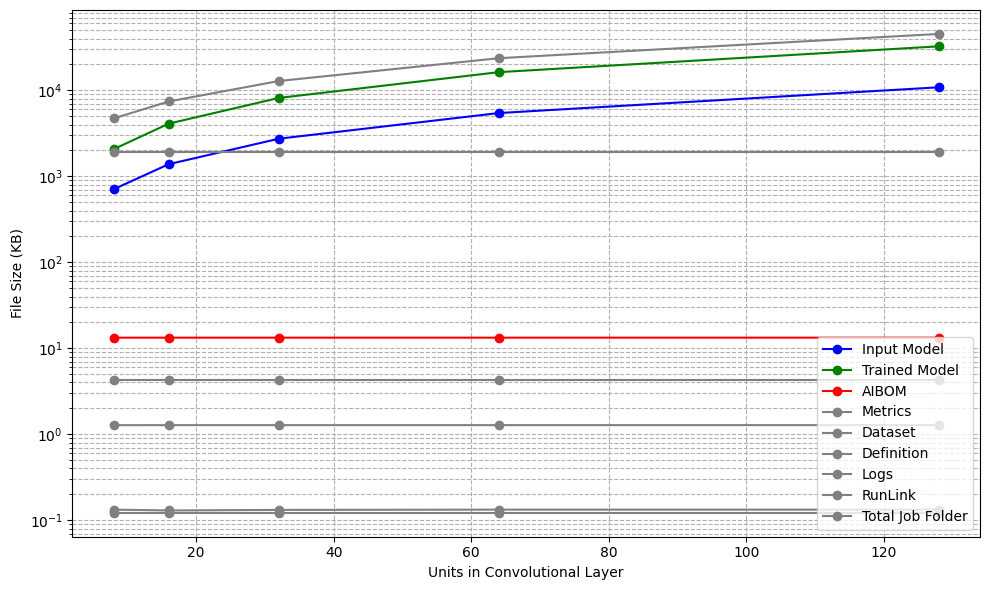

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Analyze Storage Data
# Define the path to the job result folders
results_dir = Path(DOWNLOAD_DIR)  # Use the DOWNLOAD_DIR defined earlier

# Extract data for analysis
units_list = list(model_mapping.keys())  # Extract model complexities from the mapping
dataset_sizes = []
definition_sizes = []
model_sizes = []
trained_model_sizes = []
aibom_sizes = []
logs_sizes = []
metrics_sizes = []
runlink_sizes = []
total_folder_sizes = []

# Process each job folder
for units, info in model_mapping.items():
    unique_dir = info["unique_dir"]
    folder_path = results_dir / unique_dir

    # Top-level files
    dataset_file = folder_path / "dataset" / "mnist_dataset.zip"
    definition_file = folder_path / "definition" / "mnist_definition.yaml"
    model_file = folder_path / "model" / f"mnist_model_{units}_units.keras"
    # Output files
    output_path = folder_path / "output"
    trained_model_file = output_path / "trained_model.keras"
    aibom_file = output_path / "cyclonedx_bom.json"
    logs_file = output_path / "logs.log"
    metrics_file = output_path / "metrics.json"
    runlink_file = next(output_path.glob("run_training.*.link"), None)

    # Get sizes in KB (handle missing files gracefully)
    dataset_sizes.append(dataset_file.stat().st_size / 1024 if dataset_file.exists() else None)
    definition_sizes.append(definition_file.stat().st_size / 1024 if definition_file.exists() else None)
    model_sizes.append(model_file.stat().st_size / 1024 if model_file.exists() else None)
    trained_model_sizes.append(trained_model_file.stat().st_size / 1024 if trained_model_file.exists() else None)
    aibom_sizes.append(aibom_file.stat().st_size / 1024 if aibom_file.exists() else None)
    logs_sizes.append(logs_file.stat().st_size / 1024 if logs_file.exists() else None)
    metrics_sizes.append(metrics_file.stat().st_size / 1024 if metrics_file.exists() else None)
    runlink_sizes.append(runlink_file.stat().st_size / 1024 if runlink_file and runlink_file.exists() else None)

    # Calculate total folder size in KB
    total_size = sum(f.stat().st_size for f in folder_path.rglob('*') if f.is_file()) / 1024
    total_folder_sizes.append(total_size)

# Create a DataFrame for analysis
df = pd.DataFrame({
    "Units": units_list,
    "Dataset Size (KB)": dataset_sizes,
    "Definition Size (KB)": definition_sizes,
    "Input Model Size (KB)": model_sizes,
    "Trained Model Size (KB)": trained_model_sizes,
    "AIBOM Size (KB)": aibom_sizes,
    "Logs Size (KB)": logs_sizes,
    "Metrics Size (KB)": metrics_sizes,
    "RunLink Size (KB)": runlink_sizes,
    "Total Job Folder Size (KB)": total_folder_sizes,
    "AIBOM % of Trained Model": [100 * a / m if m else None for a, m in zip(aibom_sizes, trained_model_sizes)]
})
print(df)

df.to_csv(os.path.join(DOWNLOAD_DIR, "storage_analysis_model_results.csv"), index=False)

# Plot 1: File Sizes vs Units (Log Scale)
plt.figure(figsize=(10, 6))
plt.plot(df["Units"], df["Input Model Size (KB)"], marker='o', label="Input Model", color="blue")
plt.plot(df["Units"], df["Trained Model Size (KB)"], marker='o', label="Trained Model", color="green")
plt.plot(df["Units"], df["AIBOM Size (KB)"], marker='o', label="AIBOM", color="red")
plt.plot(df["Units"], df["Metrics Size (KB)"], marker='o', label="Metrics", color="gray")
plt.plot(df["Units"], df["Dataset Size (KB)"], marker='o', label="Dataset", color="gray")
plt.plot(df["Units"], df["Definition Size (KB)"], marker='o', label="Definition", color="gray")
plt.plot(df["Units"], df["Logs Size (KB)"], marker='o', label="Logs", color="gray")
plt.plot(df["Units"], df["RunLink Size (KB)"], marker='o', label="RunLink", color="gray")
plt.plot(df["Units"], df["Total Job Folder Size (KB)"], marker='o', label="Total Job Folder", color="gray")

plt.xlabel("Units in Convolutional Layer")
plt.ylabel("File Size (KB)")
plt.yscale("log")
plt.legend(loc="lower right") 
plt.grid(True, which="both", ls="--")
plt.tight_layout()

plt.savefig(os.path.join(DOWNLOAD_DIR, "storage_analysis_model_file_sizes_vs_units.png"))

plt.show()

